In [30]:
import re
import string
import unicodedata
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from joblib import dump
from tabulate import tabulate
import xgboost as xgb

# Baixa recursos necessários do NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\augus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\augus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\augus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Carrega o conjunto de dados
dataset = pd.read_csv("C:\\fatec\\B2W-Reviews01\\B2W-Reviews01.csv")

# Mostra o tamanho do dataset original
print("Tamanho do dataset original:", dataset.shape[0], "\n")

# Remove linhas com valores em branco
dataset = dataset.dropna(subset=['review_text', 'overall_rating'])

# Mostra o tamanho do dataset alterado
print("Tamanho do dataset alterado:", dataset.shape[0], "\n")


Tamanho do dataset original: 132373 

Tamanho do dataset alterado: 129098 



C:\Users\augus\AppData\Local\Temp\ipykernel_10452\3311458984.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("C:\\fatec\\B2W-Reviews01\\B2W-Reviews01.csv")


In [4]:
# Cria uma nova coluna para classificar entre comentários positivos(2), negativos(0) ou neutros(1) com base na nota:
dataset['feeling'] = np.where(dataset['overall_rating'] < 3, 0, np.where(dataset['overall_rating'] == 3, 1, 2))

# Mostra os primeiros registros do dataset
print("Primeiros registros do dataset:")
print(tabulate(dataset.head(20), headers='keys', tablefmt='pipe'))

Primeiros registros do dataset:
|    | submission_date     | reviewer_id                                                      |   product_id | product_name                                                                                                                   | product_brand   | site_category_lv1       | site_category_lv2             | review_title                     |   overall_rating | recommend_to_a_friend   | review_text                                                                                                                                                                                                                                                         |   reviewer_birth_year | reviewer_gender   | reviewer_state   |   feeling |
|---:|:--------------------|:-----------------------------------------------------------------|-------------:|:----------------------------------------------------------------------------------------------------------------------------

In [5]:
# Pré-processamento dos dados
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('portuguese'))

preprocessed_texts = []  # Lista para armazenar os textos pré-processados

# Itera sobre cada texto no dataset para pré-processamento
for text in dataset['review_text']:
    if isinstance(text, str):  # Verifica se o texto é uma string
        # Converter para minúsculas
        text = text.lower()
        # Remover acentos
        text = ''.join(char for char in unicodedata.normalize('NFKD', text) if unicodedata.category(char) != 'Mn')
        # Remover números usando expressão regular
        text = re.sub(r'\d+', '', text)
        # Remover caracteres especiais (incluindo emojis)
        text = re.sub(r'[^\w\s]', '', text)
        # Remover pontuação
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remover espaços extras
        text = re.sub(r'\s+', ' ', text).strip()
        # Tokenização
        tokens = word_tokenize(text)
        # Lematização e remoção de stopwords
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word.lower() not in stop_words]
        # Juntar tokens em texto novamente
        preprocessed_text = ' '.join(tokens)
        preprocessed_texts.append(preprocessed_text)  # Adicionar texto pré-processado à lista
    else:
        preprocessed_texts.append("")

# Atualiza o DataFrame com os textos pré-processados
dataset['review_text'] = preprocessed_texts

# Mostra o dataset após o pré-processamento
print("\nDataset após pré-processamento:")
print(tabulate(dataset.head(20), headers='keys', tablefmt='pipe'))



Dataset após pré-processamento:
|    | submission_date     | reviewer_id                                                      |   product_id | product_name                                                                                                                   | product_brand   | site_category_lv1       | site_category_lv2             | review_title                     |   overall_rating | recommend_to_a_friend   | review_text                                                                                                                                                                                        |   reviewer_birth_year | reviewer_gender   | reviewer_state   |   feeling |
|---:|:--------------------|:-----------------------------------------------------------------|-------------:|:-------------------------------------------------------------------------------------------------------------------------------|:----------------|:------------------------|:---------------

In [6]:
# Separar os dados em features (X) e target (Y)
X = dataset['review_text'].values
Y = dataset['feeling'].values

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [7]:
# Separar os dados em features (X) e target (Y)
X = dataset['review_text'].values
Y = dataset['feeling'].values

# Criar um objeto CountVectorizer com N-grams
ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))  # Considera unigramas, bigramas e trigramas

# Vetorizar os dados de texto com N-grams
X_ngrams = ngram_vectorizer.fit_transform(X)

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, Y_train, Y_test = train_test_split(X_ngrams, Y, test_size=0.25, random_state=42)

# Criar uma instância do modelo XGBoost
xgboost = xgb.XGBClassifier()
xgboost.fit(X_train, Y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [8]:
# Avaliar o modelo com acuracia
accuracy_ngrams = xgboost.score(X_test, Y_test)
print("Acurácia:", accuracy_ngrams)


Acurácia: 0.8168861347792409


In [9]:
# Prever as classes para os dados de teste
Y_pred = xgboost.predict(X_test)

# Criar um DataFrame com as previsões e as verdadeiras classes de "feeling"
df_results = pd.DataFrame({'Feeling_Predicted': Y_pred, 'Feeling_True': Y_test})
# Substituindo os valores
df_results['Feeling_Predicted'] = df_results['Feeling_Predicted'].replace({0: 'negativo', 1: 'neutro', 2: 'positivo'})
df_results['Feeling_True'] = df_results['Feeling_True'].replace({0: 'negativo', 1: 'neutro', 2: 'positivo'})

# Mostrar os resultados
print("\nResultados de 'feeling' após o treinamento do modelo:")
print(tabulate(df_results.head(20)))  # Exibir os 20 primeiros registros



Resultados de 'feeling' após o treinamento do modelo:
--  --------  --------
 0  positivo  positivo
 1  positivo  positivo
 2  positivo  neutro
 3  negativo  negativo
 4  negativo  positivo
 5  positivo  positivo
 6  positivo  negativo
 7  positivo  neutro
 8  positivo  positivo
 9  positivo  positivo
10  positivo  positivo
11  positivo  positivo
12  positivo  positivo
13  negativo  negativo
14  positivo  positivo
15  positivo  positivo
16  neutro    positivo
17  positivo  positivo
18  positivo  neutro
19  positivo  positivo
--  --------  --------


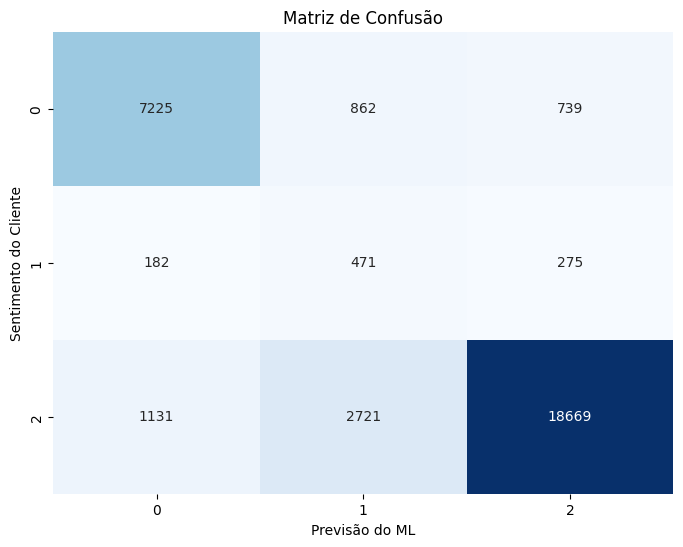

In [10]:
cm = confusion_matrix(Y_pred, Y_test)

# Avaliar o modelo com matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Previsão do ML")
plt.ylabel("Sentimento do Cliente")
plt.title("Matriz de Confusão")
plt.show()


In [11]:
# Calcular a precisão para cada classe, mede a precisão das previsões
precision_negativo = precision_score(Y_test, Y_pred, average=None)[0]
precision_neutro = precision_score(Y_test, Y_pred, average=None)[1]
precision_positivo = precision_score(Y_test, Y_pred, average=None)[2]

# Calcular o recall para cada classe, mede a capacidade do modelo de encontrar todos os exemplos
recall_negativo = recall_score(Y_test, Y_pred, average=None)[0]
recall_neutro = recall_score(Y_test, Y_pred, average=None)[1]
recall_positivo = recall_score(Y_test, Y_pred, average=None)[2]

# Calcular o F1-score para cada classe, média harmônica da precisão e do recall
f1_negativo = f1_score(Y_test, Y_pred, average=None)[0]
f1_neutro = f1_score(Y_test, Y_pred, average=None)[1]
f1_positivo = f1_score(Y_test, Y_pred, average=None)[2]

# Exibir os resultados
print("Precisão para a classe Negativo:", precision_negativo)
print("Precisão para a classe Neutro:", precision_neutro)
print("Precisão para a classe Positivo:", precision_positivo)

print("\nRecall para a classe Negativo:", recall_negativo)
print("Recall para a classe Neutro:", recall_neutro)
print("Recall para a classe Positivo:", recall_positivo)

print("\nF1-score para a classe Negativo:", f1_negativo)
print("F1-score para a classe Neutro:", f1_neutro)
print("F1-score para a classe Positivo:", f1_positivo)


Precisão para a classe Negativo: 0.8186041241785633
Precisão para a classe Neutro: 0.5075431034482759
Precisão para a classe Positivo: 0.8289596376715066

Recall para a classe Negativo: 0.8462169126259077
Recall para a classe Neutro: 0.11618154908732116
Recall para a classe Positivo: 0.9484834628867551

F1-score para a classe Negativo: 0.8321815249942409
F1-score para a classe Neutro: 0.1890806904857487
F1-score para a classe Positivo: 0.8847028717657094


In [33]:
# Calcule as pontuações de probabilidade previstas para cada classe
y_scores = xgboost.predict_proba(X_test)

# Calcule a Curva ROC e a AUC-ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(xgboost.classes_)):
    fpr[i], tpr[i], _ = roc_curve(Y_test, y_scores[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot das Curvas ROC para cada classe
plt.figure(figsize=(8, 6))
for i in range(len(xgboost.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label='Classe {} (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


In [13]:
# Salvar o modelo e o vetorizador em um único arquivo, no mesmo diretório deste notebook
dump((xgboost, ngram_vectorizer), 'modelo_xg_boost.joblib')


['modelo_xg_boost.joblib']